In [3]:
import sys
import os
import time

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from pygsp.graphs import Graph

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.model import Model, TVModel, LRModel, BLModel, MedianModel
from graph_deep_decoder.architecture import GraphDecoder, GraphDeepDecoder, Ups, Upsampling, GCNN
from graph_deep_decoder.graph_clustering import MultiResGraphClustering, Type_A

# %matplotlib qt

DATASET_PATH = '../dataset/temperatures2003_3months.npz'
MAX_SIGNALS = 100
SEED = 0
SAVE = False
PATH = '../results/temperatures/'
FILE_PREF = 'denoise_'

plt.rcParams['image.cmap'] = 'Spectral_r'

## Load dataset

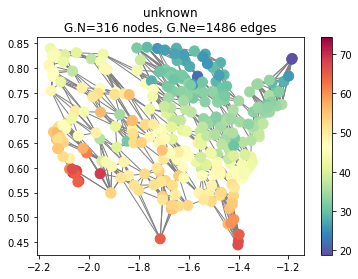

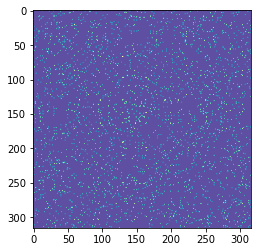

In [2]:
npzfile = np.load(DATASET_PATH)
A = npzfile['A']
A_bin = npzfile['A_bin']
X = npzfile['X']
Coords = npzfile['Coords']
n_signals = np.min([X.shape[1], MAX_SIGNALS])

G = Graph(A)
G.set_coordinates(Coords)
G.plot_signal(X[:, 31])
S = A
L = G.L.todense()

plt.figure()
plt.imshow(S)

Text(0.5, 1.0, 'x_n')

<Figure size 432x288 with 0 Axes>

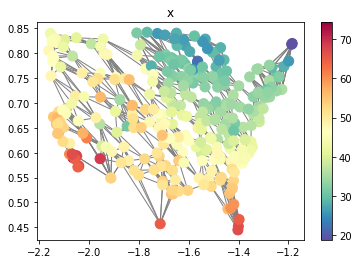

<Figure size 432x288 with 0 Axes>

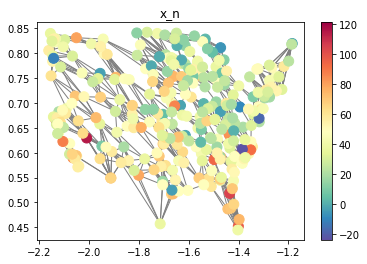

In [3]:

x = X[:, 31]
plt.figure()
G.plot_signal(x)
plt.title('x')
#plt.savefig('x.png')

x_n = ds.GraphSignal.add_noise(x, 0.2)

plt.figure()
G.plot_signal(x_n)
plt.title('x_n')
#plt.savefig('x_n.png')

## Set the expetiments

In [3]:
N_P = [0, .1, .2, .3, .4, .5]

Exps = [
        {'type': 'BL', 'alpha': .15, 'legend': 'BL'},
        {'type': 'MED','legend': 'MED'},
        {'type': 'GCNN', 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'S': S,
         'w_std': 1, 'in_std': 1, 'legend': 'GCNN'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [75]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'GD'},
        ]

# Model parameters
epochs =  1500
lr = 0.001

# Create filter H
h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False}
H = utils.create_filter(S, h_params)
H_norm = H/np.linalg.norm(H)

# Compute needed matrices
for exp in Exps:
    if exp['type'] == '2LD':
        exp['H'] = H_norm if exp['H_norm'] else H
    elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MEAN:
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0])
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As
    elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MAT:
        exp['Us'] = [H_norm] if exp['H_norm'] else [H]
        exp['Us'] = exp['Us']*(len(exp['nodes'])-2) + [None] 
        exp['As'] = []

## Plot clusrtering

<Figure size 432x288 with 0 Axes>

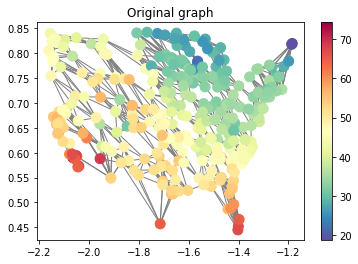

<Figure size 432x288 with 0 Axes>

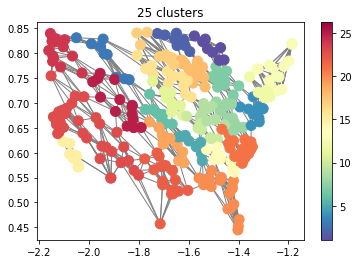

<Figure size 432x288 with 0 Axes>

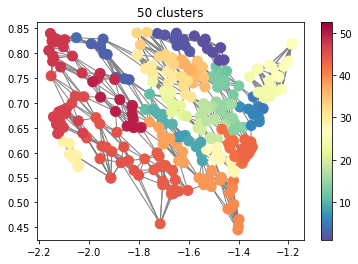

<Figure size 432x288 with 0 Axes>

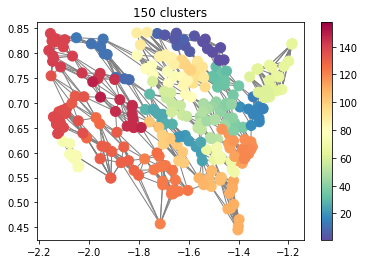

In [6]:
plt.figure()
G.plot_signal(X[:, 31])
plt.title('Original graph')
for label in clt.labels[:-2]:
    plt.figure()
    G.plot_signal(label)
    plt.title(str(np.max(label)) + ' clusters')

## Fit data and compute error

In [7]:
err = np.zeros((len(N_P), n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)
    for j in range(n_signals):
        x = X[:, j]
        x /= np.linalg.norm(x)
        x_n = ds.GraphSignal.add_noise(x, n_p)
        for k, exp in enumerate(Exps):
            if exp['type'] == 'TV':
                model = TVModel(S, exp['alpha'])
            elif exp['type'] == 'LR':
                model = LRModel(L, exp['alpha'])
            elif exp['type'] == 'BL':
                _, V = utils.ordered_eig(S)
                k_firsts = int(G.N*exp['alpha'])
                model = BLModel(V, k_firsts)
            elif exp['type'] == 'MED':
                model = MedianModel(S)
            elif exp['type'] == '2LD':
                dec = GraphDecoder(exp['fts'], exp['H'], exp['std'])
                weights[k] = G.N*exp['fts']
            elif exp['type'] == 'DD':
                dec = GraphDeepDecoder(exp['fts'], exp['nodes'], exp['Us'], batch_norm=exp['bn'],
                                       As=exp['As'], act_fn=exp['af'], ups=exp['ups'],
                                       last_act_fn=exp['laf'], input_std=exp['in_std'],
                                       w_std=exp['w_std'])
                weights[k] = dec.count_params()
            elif exp['type'] == 'GCNN':
                dec = GCNN(exp['fts'], exp['nodes'], exp['S'], input_std=exp['in_std'],
                           w_std=exp['w_std'])
                weights[k] = dec.count_params()
            else:
                raise Exception('Unkwown exp type')

            if exp['type'] in ['DD', '2LD', 'GCNN']:
                model = Model(dec, epochs=epochs, learning_rate=lr)
                _, err[i, j, k], _ = model.fit(x_n, x)
            else:
                model.fit(x_n)
                _, err_non_train = model.test(x)
                err[i, j, k] = np.repeat(err_non_train, epochs)
        print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))
median_err = np.median(err, axis=1)

Noise: 0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
Noise: 0.1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
Noise: 0.2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 
Noise: 0.3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64

### Plot results

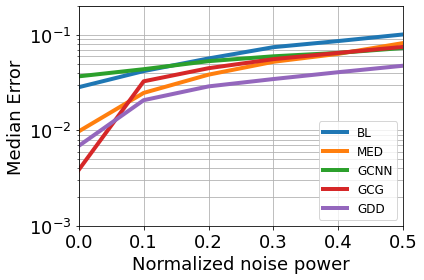

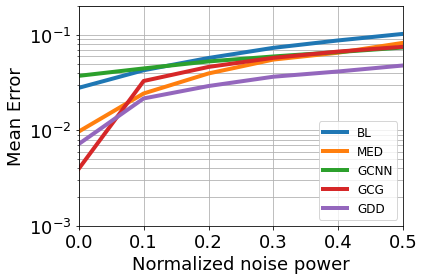

In [5]:
legend = []
for i, exp in enumerate(Exps):
    legend.append(exp['legend'])
    
# plot with variable epoch
mean_err = np.mean(err, axis=1)

best_epochs = np.argmin(median_err, axis=2)
best_epochs_mean = np.argmin(mean_err, axis=2)
best_med_err = np.zeros((len(N_P), len(Exps)))
best_mean_err = np.zeros((len(N_P), len(Exps)))
for i in range(len(N_P)):
    for j in range(len(Exps)):
        best_med_err[i, j] = median_err[i, j, best_epochs[i, j]]
        best_mean_err[i, j] = mean_err[i, j, best_epochs_mean[i, j]]
        
        
fig3 = plt.figure()
plt.semilogy(N_P, best_med_err, linewidth=4)
plt.legend(legend, prop={'size': 12})
plt.grid(True, which='both')
plt.xlabel('Normalized noise power',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xlim([0, 0.5])
plt.ylim([1e-3, 0.2])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
# fig3.savefig(PATH + 'denoise_temp_all_pn.eps')

fig4 = plt.figure()
plt.semilogy(N_P, best_mean_err, linewidth=4)
plt.legend(legend, prop={'size': 12})
plt.grid(True, which='both')
plt.xlabel('Normalized noise power',fontsize=18)
plt.ylabel('Mean Error',fontsize=18)
plt.xlim([0, 0.5])
plt.ylim([1e-3, 0.2])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
#fig4.savefig(PATH + 'denoise_temp_all_pn.eps')



In [ ]:
figs = []
for i, n_p in enumerate(N_P):
    print('N_P:', n_p)
    err_np = median_err[i]
    figs.append(plt.figure())
    plt.semilogy(err_np.T)
    plt.grid(True, which='both')
    plt.legend(legend)
    plt.title('Median MSE - noise: {}'.format(n_p))
    plt.xlim(left=0, right=err.shape[-1])
    plt.tight_layout()
    
    print('Min err:', )
    epochs = np.argmin(median_err, axis=2)
    for j in range(len(Exps)):
        epoch = epochs[i, j]
        print('\tModel {}: Err: {} Epoch: {}'.format(j, median_err[i, j, epoch],
                                                     epoch))
        
    # figs[i].savefig(PATH + 'denoise_temp_n{}.png'.format(n_p))

In [13]:
if False:
    data = {
        'seed': SEED,
        'N_P': N_P,
        'exps': Exps,
        'err': err,
        'h_params': h_params,
        'lr': lr,
        'weights': weights,
        'legend': legend,
        'fmts': [],
    }
    utils.save_results(FILE_PREF, PATH, data)
    
    

SAVED as: C:\Users\Samuel\Documents\GitHub\Graph_Deep_Decoder\2Layer_Decoder_Exps ../results/temperatures/denoise_2021_06_14-19_11


In [4]:
# # LOAD
# file = '../results/temperatures/denoise_2021_06_14-19_11.npy'
# data = np.load(file,allow_pickle=True).item()
# err = data['err']
# Exps = data['exps']
# N_P = data['N_P']
# SEED = data['seed']
# h_params = data['h_params']
# lr = data['lr']
# weights = data['weights']

# median_err = np.median(err, axis=1)

In [ ]:
plt.show()